<a href="https://colab.research.google.com/github/janpeter19/BPL_CHO_Fedbatch/blob/main/BPL_CHO_Perfusion_cspr_opennloop_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BPL_CHO_Perfusion_cspr_openloop script with PyFMI

The key library PyFMI is installed.

After the installation a small application BPL_CHO_Pefusion_cspr_openloop is loaded and run. You can continue with this example if you like.

In [ ]:
!lsb_release -a # Actual VM Ubuntu version used by Google

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy


In [ ]:
%env PYTHONPATH=

env: PYTHONPATH=


In [ ]:
!python --version

In [ ]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-py311_24.11.1-0-Linux-x86_64.sh
!chmod +x Miniconda3-py311_24.11.1-0-Linux-x86_64.sh
!bash ./Miniconda3-py311_24.11.1-0-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.11/site-packages/')

--2024-06-14 13:02:23--  https://repo.anaconda.com/miniconda/Miniconda3-py310_23.1.0-1-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74403966 (71M) [application/x-sh]
Saving to: ‘Miniconda3-py310_23.1.0-1-Linux-x86_64.sh’

Miniconda3-py310_23 100%[===================>]  70.96M   120MB/s    in 0.6s    

2024-06-14 13:02:24 (120 MB/s) - ‘Miniconda3-py310_23.1.0-1-Linux-x86_64.sh’ saved [74403966/74403966]

PREFIX=/usr/local
Unpacking payload ...
                                                                                                    
Installing base environment...





Preparing transaction: - \ | / - \ done
Executing transaction: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ 

In [ ]:
!conda update -n base -c defaults conda --yes

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.5.0



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotli-python-1.0.9        |  py310h6a678d5_8         356 KB
    bzip2-1.0.8                |       h5eee18b_6         262 KB
    ca-certificates-2024.3.11  |       h06a4308_0         127 KB
    certifi-2024.6.2           |  py

In [ ]:
!conda --version
!python --version

conda 23.1.0
Python 3.10.14


In [ ]:
!conda config --set channel_priority strict

In [ ]:
!conda install -c conda-forge pyfmi --yes # Install the key package

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | 

# BPL_CHO_Perfusion_cspr_openloop setup


Now specific installation and the run simulations. Start with connecting to Github. Then upload the two files:

* FMU - BPL_CHO_Perfusion_cspr_openloop_linux_om_me.fmu
* Setup-file - BPL_CHO_Perfusion_cspr_openloop_explore

In [ ]:
# Filter out DepracationWarnings for 'np.float as alias' is needed - wish I could make filter more narrow
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%bash
git clone https://github.com/janpeter19/BPL_CHO_Perfusion_cspr

Cloning into 'BPL_CHO_Perfusion'...


In [ ]:
%cd BPL_CHO_Perfusion_cspr

/content/BPL_CHO_Perfusion


# BPL CHO Perfusion cspr openloop - demo
Author: Jan Peter Axelsson

This notebook is about CHO perfusion cultivation and focus on the concept of Cell Specific Perfusion Rate (CSPR).  Recombinant protein production is included in the model but not shown in the diagrams here.

The model used here was orignally developed and validated for fed-batch cultivation of CHO cultures [1], but also got some influence from perfusion cultivation [2]. The model emphasize the bottlenecks of metabolism and growth and inspired from similar models of microbial cultures. One interesting aspect is that the model brings a theoretical base for the usefulness of the CSPR concept often used experimentally [4] and [5]. The results of simulation shown here are in accordance with experiments in a qualititative way, howerver not tested more quantitatively, to the authors knowledge.

The main result is that when the perfusion rate should be increased from one set-point to another, it should be changed slowly. An abrupt step-wise increase should be avoided. A slow increase in the pefusion rate minimize the risk of unnecessary by-product formation of lactate and amonia and make the culture increase in cell concentration quicker to a new steady-state compared to a step-wise perfusion rate change. The rate of change of perfusion rate should not exceed the maximal culture growth rate.

The strategy to limit rate of change of perfusion rate is much more important for mammalian cultures than for microbial cultures. The reason is that mammalian cell cutures increase in cell density after an inrease in perfusion rate, while mibrobial cultures remains constant in cell density.  This difference is most likely due to the fact that maintenance metabolism is a larger part in mammalian cultures and at higher growth rates the percentage of maintenance becomes smaller and the overall yield increase, while microbial cultures has a much more contsant yield over a broad range of growth rates. These ideas are discussed in section 2.2 in [3], together with other insights into perfusion cultivation obtained from simulation studies of the current model.

Once again, it would be good to compare simulations with relevant experimental data from perfusion cultivation. Hopefully, the material presented here can stimulate work in this direction.




## Setup of the simulation model

In [ ]:
run -i BPL_CHO_perfusion_cspr_openloop_explore.py

Linux - run FMU pre-comiled OpenModelica

Model for bioreactor has been setup. Key commands:
 - par()       - change of parameters and initial values
 - init()      - change initial values only
 - simu()      - simulate and plot
 - newplot()   - make a new plot
 - show()      - show plot from previous simulation
 - disp()      - display parameters and initial values from the last simulation
 - describe()  - describe culture, broth, parameters, variables with values/units

Note that both disp() and describe() takes values from the last simulation
and the command process_diagram() brings up the main configuration

Brief information about a command by help(), eg help(simu)
Key system information is listed with the command system_info()


In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [25/2.54, 20/2.54]

## About the process model
Here a process diagram is shown of the process. Further information about the culutre stored in the model code is extracted.

No processDiagram.png file in the FMU, but try the file on disk.


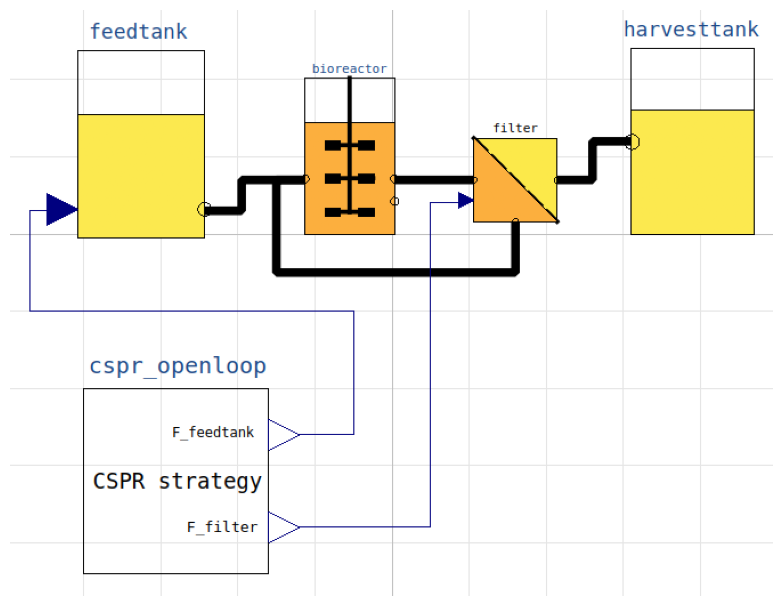

In [ ]:
process_diagram()

In [ ]:
describe('culture'); print(); #describe('liquidphase')

Reactor culture CHO-MAb - cell line HB-58 American Culture Collection ATCC



## Simulaton study
The simulations are run with default parameters from [1]. The parameters for the change of perfusion rate is done here. The parameter mu_ref gives the rate of increase in [1/h]. With the value mu_ref=1 you get an abrupt step directly to the set-point. The parameters F1 and F2 give the flow rate [L/h] before and after the change. The corresponding time parameters t1 and t2 are given by default.

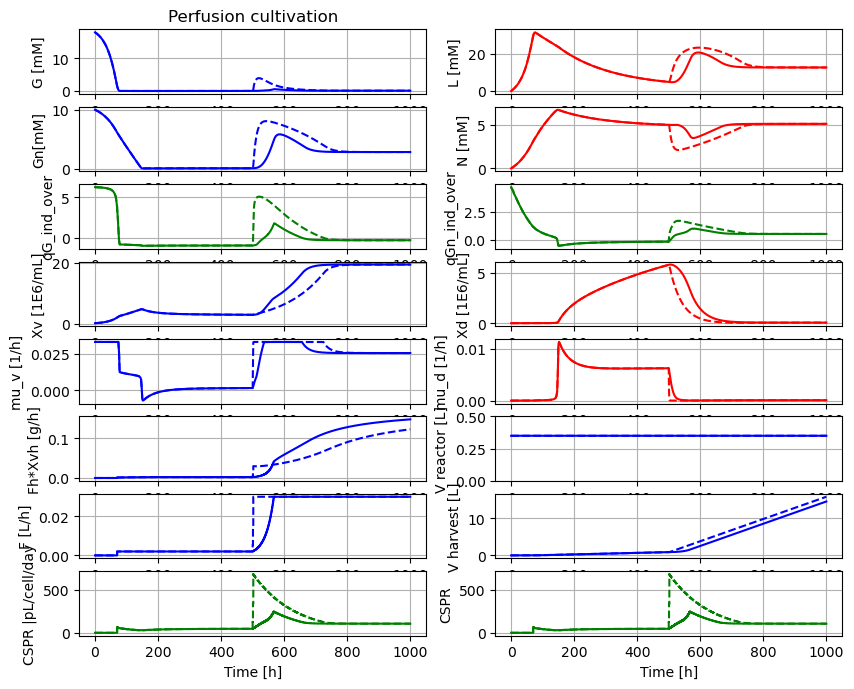

In [ ]:
newplot('Perfusion cultivation', plotType='Extended')

par(samplePeriod=1); par(F1=0.0020, F2=0.030)    # General parameters
par(mu_ref=0.04); simu()                         # First simulation (solid)
par(mu_ref=1); simu()                            # Second simulation (dashed)

We see here the shorter settling time for cell conc Xv when the slower exponential increase of perfusion rate is used, compared to an abrupt change.

The different sets of parameters that can be changed are shown below

In [ ]:
disp(mode='long')

bioreactor.V_start : V_start : 0.35
bioreactor.m_start[1] : VXv_start : 0.07
bioreactor.m_start[2] : VXd_start : 0.0
bioreactor.m_start[3] : VG_start : 6.3
bioreactor.m_start[4] : VGn_start : 3.5
bioreactor.m_start[5] : VL_start : 0.0
bioreactor.m_start[6] : VN_start : 0.0
bioreactor.culture.qG_max1 : qG_max1 : 0.297
bioreactor.culture.qG_max2 : qG_max2 : 0.038
bioreactor.culture.qGn_max1 : qGn_max1 : 0.124
bioreactor.culture.qGn_max2 : qGn_max2 : 0.022
bioreactor.culture.mu_d_max : mu_d_max : 0.13
bioreactor.broth_decay.k_lysis : k_lysis : 0.0
filter.eps : eps : 0.1
filter.alpha[1] : alpha_Xv : 0.03
filter.alpha[2] : alpha_Xd : 0.03
filter.alpha[3] : alpha_G : 0.1
filter.alpha[4] : alpha_Gn : 0.1
filter.alpha[5] : alpha_L : 0.1
filter.alpha[6] : alpha_N : 0.1
filter.alpha[7] : alpha_Pr : 0.1
feedtank.c_in[3] : G_in : 15.0
feedtank.c_in[4] : Gn_in : 11.0
cspr_openloop.samplePeriod : samplePeriod : 1.0
cspr_openloop.mu_ref : mu_ref : 1.0
cspr_openloop.t1 : t1 : 70.0
cspr_openloop.F1 : F

Some other important parameters for information, but cannot be changed.

In [ ]:
describe('bioreactor.broth_decay.k_decay')

Rate of decay of viable cells : 0.0 [ 1E9 cells/(L*h) ]


In [ ]:
describe('k_lysis')

Specific rate of lysis of dead cells : 0.0 [ 1/h ]


Now a new simulation where the flow rate F1 is higher before change to the new set-point F2.

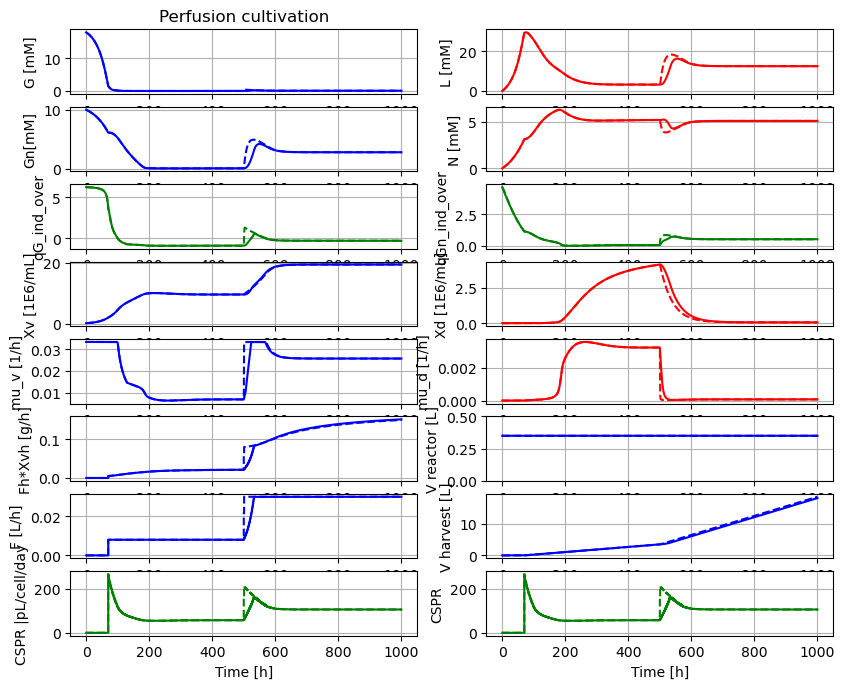

In [ ]:
newplot('Perfusion cultivation', plotType='Extended')

par(samplePeriod=1); par(F1=0.0080, F2=0.03)      # General parameters
par(mu_ref=0.04); simu()                          # First simulation (solid)
par(mu_ref=1); simu()                             # Second simulation (dashed)

We see that a somewhat smaller change in perfusion rate make the differnce in settling time of Xv for the two strategies to almost disappear.

## Summary
The simulation study shows that a slow increase in the perfusion rate that match the maximal culture growth rate gives a quicker increase in cell density than an abrupst step-wise change of perfusion rate.

The effect is more pronounced for a larger change of perfusion rate than for a smaller.

Here the change of perfusion rate was done usering a pre-calculated exponential scheme, i.e. open-loop control. A more robust method would be to measure the cell concentration on-line and adjust the perfusion rate change to more exactly maintan constant CSPR.

It is of interest to confirm the results with experimental data.

## References
[1] Amribt, Z., Niu, H. and Bogaerts P.: "Macroscopic modelling of overflow metabolism and model based optimization of hybridoma cell fed-batch cultures.", Biochem. Eng. Journal, 2013.

[2] Niu,H., Amribt, Z., Fickers, P., Tan, W. and Bogaerts P.: "Metabolic pathway analysis and reduction for mammalian cell cultures - towards macroscopic modelling", Chem. Eng. Science, 2013.

[3] Axelsson, J. P.: "Simplified model of CHO-cultivation in Bioproces Library for Modelica - some experience", conference paper 22nd NPCW Lyngby, Denmark, August 22-23, 2019.

[4] Hu, W-S: "Cell culture bioprocess engineering", 2nd edition, CRC Press, 2020.

[5] Konstantinov, K. et al: "The push-to-low" approach for optimization of high density perfusion cultures of animal cells", Adv Biochem Engin/Biotechnol, 2006.

## Appendix

In [ ]:
describe('parts')

['bioreactor', 'bioreactor.broth_decay', 'bioreactor.culture', 'CSPR', 'cspr_openloop', 'D', 'feedtank', 'filter', 'harvesttank']


In [ ]:
describe('MSL')

MSL: 3.2.3 - used components: RealInput, RealOutput, CombiTimeTable, Types


In [ ]:
system_info()


System information
 -OS: Linux
 -Python: 3.10.14
 -Scipy: not installed in the notebook
 -PyFMI: 2.13.0
 -FMU by: OpenModelica Compiler OpenModelica 1.23.1
 -FMI: 2.0
 -Type: FMUModelME2
 -Name: BPL_CHO.Perfusion_cspr_openloop
 -Generated: 2024-08-29T11:07:05Z
 -MSL: 3.2.3
 -Description: Bioprocess Library version 2.2.1 - GUI
 -Interaction: FMU-explore version 1.0.0
